<a href="https://colab.research.google.com/github/manumeehl/trajectories/blob/main/trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install tesseract-ocr
!pip install opencv-python-headless pytesseract pytube

In [178]:
from google.colab.patches import cv2_imshow as show
from pytube import YouTube
import pandas as pd
import pytesseract
import math
import cv2
import re

In [ ]:
def get_video(url, path):
  vid = YouTube(url)
  print(f"Downloading Video '{vid.streams[0].title}'")
  vid.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first().download(output_path=path, filename='launch.mp4')
  print('Download complete')

In [194]:
def custom_crop(frame):
  height, width, _ = frame.shape
  return frame[height-140:height,0:1920]

def crop_roi(frame, roi):
  ''' Extract from a list of predefined regions of interest (ROI) '''
  height, width, _ = frame.shape

  if roi == 'Clock':
    return frame[height-120:height-40,int(width/2-200):int(width/2+200)]
  if roi == 'Stage 1':
    return frame[height-140:height,0:500]
  elif roi == 'Stage 2':
    return frame[height-140:height,width-500:width]

In [159]:
def clock_to_secs(clockstring):
  ''' Convert a mission clock string to an integer second value '''
  tense = -1 if clockstring[:2] == 't-' else 1
  # Remove the T+- sign
  clockstring = clockstring [2:]
  # Get the seconds
  units = clockstring.split(':')
  hours = int(units[0])
  minutes = int(units[1])
  seconds = int(units[2])

  return hours * 3600 + minutes * 60 + seconds

def frame_to_elapsed(framepos):
  # Calculate the exact time since liftoff based on the current frame
  return  round((framepos - liftoff_frame) / fps, 2)

In [193]:
def get_props(string):
  ''' Extract mission clock, altitude and velocity from a given string '''
  string = string.lower()

  # Apply a blacklist
  blacklist = ['stage 1', 'stage 2', 'falcon 9']
  for w in blacklist:
    string = string.replace(w, '')

  # Find all numbers and floats in the string
  numbers = re.findall(r'\d+(?:\.\d+)?', string)

  # Find the mission clock (T+00:00:00)
  mission_clock = re.findall(r't[+-]\d{2}:\d{2}:\d{2}', string)

  if mission_clock:
    mission_clock = mission_clock[0]

    # Remove numbers which also occur in the mission clock
    mission_clock_numbers = re.findall(r'\d+(?:\.\d+)?', ' '.join(mission_clock))
    for num in mission_clock_numbers:
      if num in numbers:
        numbers.remove(num)

    # Calculate the elapsed amount of seconds
    elapsed = clock_to_secs(mission_clock)
  else:
    mission_clock = ''
    elapsed = 0

  # Remove duplicates from the numbers list
  numbers = list(set([float(x) for x in numbers]))

  altitude, velocity = 0, 0
  if numbers:
    altitude = min(numbers)
    velocity = max(numbers)

  # Return the sorted numbers and mission clock
  return {
      'Clock': mission_clock,
      'Elapsed': elapsed,
      'Velocity': velocity,
      'Altitude': altitude
  }

def get_trajectory_from_string(string):
  ''' Extract altitude and velocity from a given string '''
  string = string.lower()

  # Apply a blacklist
  blacklist = ['stage 1', 'stage 2', 'falcon 9', 'starlink']
  for w in blacklist:
    string = string.replace(w, '')

  # Find all numbers and floats in the string
  numbers = re.findall(r'\d+(?:\.\d+)?', string)
  numbers = [float(x) for x in numbers]

  return {
      'altitude': min(numbers),
      'velocity': max(numbers)
  }

def get_clock_from_string(string):
  ''' Extract mission clock, altitude and velocity from a given string '''
  string = string.lower()

  # Find the mission clock (T+00:00:00)
  mission_clock = re.findall(r't[+-]\d{2}:\d{2}:\d{2}', string)

  if mission_clock:
    return {
        'clock': mission_clock,
    }

In [ ]:
def extract_data(frame):
  crop = custom_crop(frame)
  gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
  inverted = cv2.bitwise_not(gray)

  text = pytesseract.image_to_string(inverted)
  return get_props(text)

In [ ]:
def await_liftoff():
  ''' Identify the frame at which liftoff occurs '''
  framepos = 0
  interval = 300
  clock = ''
  # Await first mission clock appearance
  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    framepos += interval

    ret, frame = vid.read()
    data = extract_data(frame)

    if data['Clock']:
      clock = data['Clock']
      break

  # Now wait until the next full second
  interval = 1
  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    framepos += interval

    ret, frame = vid.read()
    data = extract_data(frame)

    if data['Clock'] and data['Clock'] != clock:
      framepos += data['Elapsed'] * fps
      return framepos


In [189]:
def floor_tenth(number):
    return math.floor(number * 10) / 10

def process_launch(vid, liftoff_frame):
  interval = 1

  framepos = liftoff_frame

  monitor = pd.DataFrame(columns = ['Clock', 'Elapsed', 'Altitude', 'Velocity'])

  curr_elapsed = 0.0

  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    elapsed = frame_to_elapsed(framepos)
    framepos += interval

    if math.floor(elapsed) >= curr_elapsed:
      # Fetch for this timeframe
      ret, frame = vid.read()
      data = extract_data(frame)

      if data['Clock']:
        print(elapsed, curr_elapsed)
        data['Elapsed'] = math.floor(elapsed)
        monitor.loc[len(monitor)] = data
        curr_elapsed += 1

    if framepos > liftoff_frame + 100:
      break

  return monitor

In [ ]:
url = 'https://www.youtube.com/watch?v=agYuEAkEljw'
get_video(url, 'launches')

Download complete


In [158]:
vidpath = 'launches/launch.mp4'
vid = cv2.VideoCapture(vidpath)
fps = vid.get(cv2.CAP_PROP_FPS)

print('Awaiting liftoff')
liftoff_frame = await_liftoff()
print('Liftoff registered, now monitoring launch')

#vid.set(cv2.CAP_PROP_POS_FRAMES, int(liftoff_frame))
#ret, frame = vid.read()
#show(frame)

Awaiting liftoff
Liftoff registered, now monitoring launch


In [190]:
trajectory = process_launch(vid, liftoff_frame)
trajectory.to_csv('trajectory.csv')

0.0 0.0
1.0 1.0
2.0 2.0
3.27 3.0


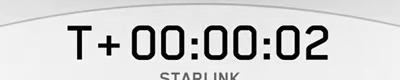

{'altitude': 0.0, 'velocity': 7.0}


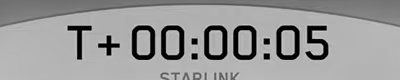

{'altitude': 0.0, 'velocity': 38.0}


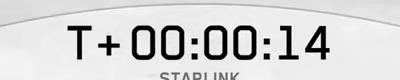

{'altitude': 2.0, 'velocity': 184.0}


In [195]:
def extract_data_dev(frame):
  # Extract telemetry of Stage 1
  crop = crop_roi(frame, 'Stage 1')
  gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
  inverted = cv2.bitwise_not(gray)
  trajectory = get_trajectory_from_string(
      pytesseract.image_to_string(inverted))

  # Extract telemetry of the Mission Clock
  crop = crop_roi(frame, 'Clock')
  gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
  inverted = cv2.bitwise_not(gray)
  show(inverted)
  clock = get_trajectory_from_string(
      pytesseract.image_to_string(inverted))

  return {**clock, **trajectory}

for i in range(3):
  frame = cv2.imread(f'frames/frame_{i+1}.png')
  data = extract_data_dev(frame)
  print(data)